# ⚙️ | Configuration

In [1]:
class CFG:
    # FLAG
    TRAIN = True
    TEST = True
    LOAD_CKPT = False # If Set True, MODEL_DIR, MODEL_NAME must be specified
    TEST_WOFT = False # TEST without fine-tuning
    MAKE_SUBMISSION = False # If Set True, 'make {WORKING_PATH}/submission.csv' too
    
    # PATH
    #/kaggle
    #   /input
    #       /train and test
    #   /{WORKING_PATH}
    #       /model
    #           /{MODEL_DIR}                (MODEL SAVE PATH)    = Preset * train_data_folder
    #               {MODEL_NAME}.keras      (MODEL FILE)         = train_data_file * DataNum * Epoch * Fold
    #       /test
    #           /{MODEL_DIR}                (TEST for MODEL)     = same with MODEL_DIR
    #               /{TEST_DIR}             (TEST PATH)          = MODEL_NAME * test_data_folder
    #                   {TEST_NAME}.csv     (TEST FILE)          = test_data_file * DataNum * accuracy
    TRAIN_DATA = './kaggle/input/daigt-proper-train-dataset/train_drcat_01.csv'
    TEST_DATA = './kaggle/input/feedback-prize-effectiveness/train.csv'
    WORKING_PATH = './kaggle/working/'
    # (Just Folder or File Name, Not whole PATH and ".keras") 
    # If None, ({preset})_({train_file_name})
    MODEL_DIR = None
    # If None, {num_of_train/1000}K_{epochs}E_{fold}F.keras
    MODEL_NAME = None
    # If None, {MODEL_NAME}_({test_data_folder})
    TEST_DIR = None
    # If None, {test_data_file}_{num_of_test / 1000}K_({accuracy}){i}.csv
    TEST_NAME = None
    
    # CSV
    #   id: if None, then create a new id using range(num_of_...data)
    #   label: If 0 or 1, then create a new label where all values are 0 or 1
    train_att = {
        'id': None, 
        'text': 'text',
        'label': 'label'
    }
    test_att = {
        'id': 'discourse_id', 
        'text': 'discourse_text',
        'label': 0
    }
    
    # HYPER PARAM
    num_of_train = 5000 # total num of train dataset
    num_of_test = 1000 # total num of test dataset
    seed = 42  # Random seed
    num_folds = 5  # Total folds
    selected_folds = [0]  # Folds to train on
    epochs = 3 # Training epochs
    batch_size = 20  # Batch size
    drop_remainder = True  # Drop incomplete batches
    sequence_length = 200  # Input sequence length
    scheduler = 'cosine'  # Learning rate scheduler

    
    # RECORD
    verbose = 0  # Verbosity
    wandb = True  # Weights & Biases logging
    competition = 'llm-detect-ai-generated-text'  # Competition name
    _wandb_kernel = 'dinleo11'  # WandB kernel
    comment = 'DebertaV3-MaxSeq_200-ext_s-torch'  # Comment description
    preset = "deberta_v3_small_en"  # Name of pretrained models
    device = 'GPU'  # Device
    cache = True # Caches data after one iteration, use only with `TPU` to avoid OOM
    
    # CLASS
    class_names = ["real", "fake"]  # Class names [A, B, C, D, E]
    num_classes = len(class_names)  # Number of classes
    class_labels = list(range(num_classes))  # Class labels [0, 1, 2, 3, 4]
    label2name = dict(zip(class_labels, class_names))  # Label to class name mapping
    name2label = {v: k for k, v in label2name.items()}  # Class name to label mapping
    
    # Name
    if MODEL_DIR is None:
        train_data_folder = TRAIN_DATA.split('/')[-2]
        MODEL_DIR = f'({preset})_({train_data_folder})'
    
    if MODEL_NAME is None:
        train_data_file = TRAIN_DATA.split('/')[-1].split('.')[0]
        MODEL_NAME = f'{num_of_train / 1000}K_{epochs}E'
    
    if TEST_DIR is None:
        test_data_folder = TEST_DATA.split('/')[-2]
        TEST_DIR = f'{test_data_folder}'

    if TEST_NAME is None:
        test_data_file = TEST_DATA.split('/')[-1].split('.')[0]
        TEST_NAME = f'({test_data_file})_{num_of_test / 1000}K' 
    TEST_DIR = f'{WORKING_PATH}/test/{MODEL_DIR}/({MODEL_NAME})_({TEST_DIR})/'
    MODEL_DIR = f'{WORKING_PATH}/model/{MODEL_DIR}/'

# 🛠 | Install Libraries 

In [2]:
# !pip install keras-core==0.1.7
# !pip install keras-nlp==0.6.3
# !pip install --upgrade wandb git+https://github.com/soumik12345/wandb-addons

# 📚 | Import Libraries 

In [3]:
import os
import dotenv
os.environ["KERAS_BACKEND"] = "torch" 
import keras_nlp
import keras_core as keras
import keras_core.backend as K
from sklearn.model_selection import StratifiedKFold  # Import package

import torch
import tensorflow as tf


import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl


cmap = mpl.cm.get_cmap('coolwarm')

Using PyTorch backend.


C:\Users\dinle\AppData\Local\Temp\ipykernel_42112\2858935862.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


## Library Version

In [4]:
print("Torch:", torch.__version__)
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasNLP:", keras_nlp.__version__)
torch.cuda.is_available()

Torch: 2.1.1+cu118
TensorFlow: 2.10.1
Keras: 0.1.7
KerasNLP: 0.6.3


True

# ♻️ | Reproducibility 
Sets value for random seed to produce similar result in each run.

In [5]:
keras.utils.set_random_seed(CFG.seed)

# 💾 | Hardware
Following codes automatically detects hardware (TPU or GPU). 

In [6]:
def get_device():
    "Detect and intializes GPU/TPU automatically"
    try:
        # Connect to TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() 
        # Set TPU strategy
        strategy = tf.distribute.TPUStrategy(tpu)
        print(f'> Running on TPU', tpu.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device=CFG.device
    except:
        # If TPU is not available, detect GPUs
        gpus = tf.config.list_logical_devices('GPU')
        ngpu = len(gpus)
         # Check number of GPUs
        if ngpu:
            # Set GPU strategy
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            # Print GPU details
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            # If no GPUs are available, use CPU
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy()
            device='CPU'
    return strategy, device

In [7]:
# Initialize GPU/TPU/TPU-VM
strategy, CFG.device = get_device()
CFG.replicas = strategy.num_replicas_in_sync

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
> Running on GPU | Num of GPUs:  1


# 📖 | Meta Data 
* `{test|train}_essays.csv`
    * `essay_id` - A unique identifier for each essay.
    * `source, prompt_id` - Identifies the source, prompt the essay was written in response to.
    * `text` - The essay text itself.
    * `label` - Whether the essay was written by a student (0) or generated by an LLM (1). This field is the target and is not present in test_essays.csv.
* **sample_submission.csv** - is the valid sample submission.

In [8]:
def make_df(is_train):
    if is_train:
        read_path = CFG.TRAIN_DATA
        data_att = CFG.train_att
        sample_num = CFG.num_of_train
    else:
        read_path = CFG.TEST_DATA
        data_att = CFG.test_att
        sample_num = CFG.num_of_test
        
    read_df = pd.read_csv(read_path) 
    if data_att['label'] == 0 or data_att['label'] == 1:
        read_df = read_df.sample(sample_num)
        read_df['label'] = data_att['label']
    else:
        read_df = pd.concat([
            read_df[read_df[data_att['label']]==0].sample(sample_num // 2),
            read_df[read_df[data_att['label']]==1].sample(sample_num // 2)
        ])
        read_df['label'] = read_df[data_att['label']]
        
    if data_att['id'] is None:
        read_df['id'] = range(sample_num)
    else:
        read_df['id'] = read_df[data_att['id']]
        
    return_df = pd.DataFrame({
        'id': read_df['id'],
        'text': read_df[data_att['text']],
        'label': read_df['label'],
        'label_name': read_df['label'].map(CFG.label2name)
    })
    
    return return_df.reset_index(drop=True)

def show_df(org_df):
    plot_df = org_df.copy()

    # Display information about the external data
    print("# External Data: {:,}".format(len(plot_df)))
    print("# Sample:")

    # Show distribution of answers using a bar plot
    plt.figure(figsize=(8, 4))
    plot_df['label_name'].value_counts().plot.bar(color=[cmap(0.0), cmap(0.65)])
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title("Answer distribution for External Data")
    plt.show()
    return plot_df.head(5)

def split_df(org_df):
    skf = StratifiedKFold(n_splits=CFG.num_folds, shuffle=True, random_state=CFG.seed)  # Initialize K-Fold

    return_df = org_df.reset_index(drop=True)  # Reset dataframe index
    
    return_df['stratify'] = return_df.label.astype(str)
    
    return_df["fold"] = -1  # New 'fold' column
    
    # Assign folds using StratifiedKFold
    for fold, (train_idx, val_idx) in enumerate(skf.split(return_df, return_df['stratify'])):
        return_df.loc[val_idx, 'fold'] = fold
    
    # Display label distribution for each fold
    print(return_df.groupby(["fold", "label_name"]).size())
    
    return return_df

### Train Data

# External Data: 5,000
# Sample:


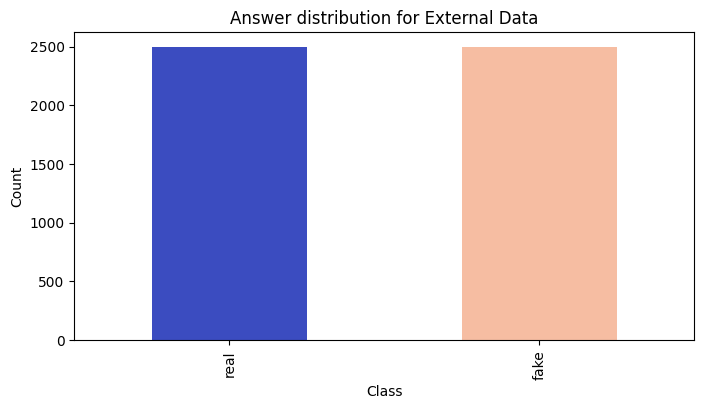

In [9]:
if CFG.TRAIN:
    train_df = make_df(True)
    show_df(train_df)

# 🔪 | Data Split

In the code snippet provided below, we will divide the existing **train** data into folds using a stratification of `label` column.

In [10]:
if CFG.TRAIN:
    train_df = split_df(train_df)

fold  label_name
0     fake          500
      real          500
1     fake          500
      real          500
2     fake          500
      real          500
3     fake          500
      real          500
4     fake          500
      real          500
dtype: int64


### Test Data

# External Data: 1,000
# Sample:


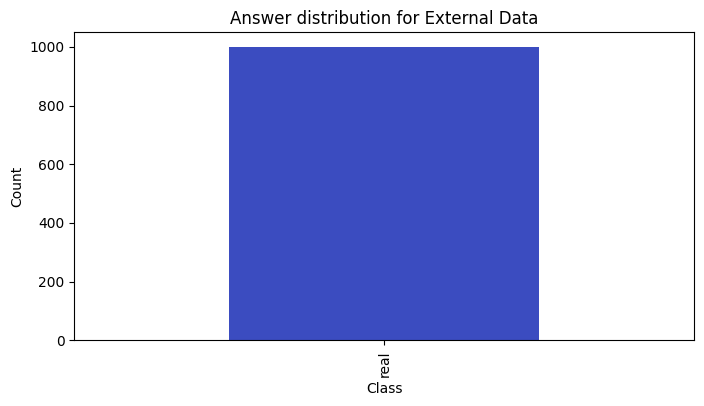

In [11]:
if CFG.TEST:
    test_df = make_df(False)
    show_df(test_df)

# 🍽️ | Preprocessing

**What it does:** The preprocessor takes input strings and transforms them into a dictionary (`token_ids`, `padding_mask`) containing preprocessed tensors. This process starts with tokenization, where input strings are converted into sequences of token IDs.

**Why it's important:** Initially, raw text data is complex and challenging for modeling due to its high dimensionality. By converting text into a compact set of tokens, such as transforming `"The quick brown fox"` into `["the", "qu", "##ick", "br", "##own", "fox"]`, we simplify the data. Many models rely on special tokens and additional tensors to understand input. These tokens help divide input and identify padding, among other tasks. Making all sequences the same length through padding boosts computational efficiency, making subsequent steps smoother.

Explore the following pages to access the available preprocessing and tokenizer layers in **KerasNLP**:
- [Preprocessing](https://keras.io/api/keras_nlp/preprocessing_layers/)
- [Tokenizers](https://keras.io/api/keras_nlp/tokenizers/)

In [12]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset, # Name of the model
    sequence_length=CFG.sequence_length, # Max sequence length, will be padded if shorter
)

Now, let's examine what the output shape of the preprocessing layer looks like. The output shape of the layer can be represented as $(num\_choices, sequence\_length)$.

In [13]:
if CFG.TRAIN:
    inp = preprocessor(train_df.text.iloc[0])  # Process text for the first row

    # Display the shape of each processed output
    for k, v in inp.items():
        print(k, ":", v.shape)

token_ids : torch.Size([200])
padding_mask : torch.Size([200])


We'll use the `preprocessing_fn` function to transform each text option using the `dataset.map(preprocessing_fn)` method.

In [14]:
def preprocess_fn(text, label=None):
    text = preprocessor(text)  # Preprocess text
    return (text, label) if label is not None else text  # Return processed text and label if available

# 🍚 | DataLoader

The code below sets up a robust data flow pipeline using `tf.data.Dataset` for data processing. Notable aspects of `tf.data` include its ability to simplify pipeline construction and represent components in sequences.

To learn more about `tf.data`, refer to this [documentation](https://www.tensorflow.org/guide/data).

In [15]:
def build_dataset(texts, labels=None, batch_size=32,
                  cache=False, drop_remainder=True,
                  repeat=False, shuffle=1024):
    AUTO = tf.data.AUTOTUNE  # AUTOTUNE option
    slices = (texts,) if labels is None else (texts, labels)  # Create slices
    ds = tf.data.Dataset.from_tensor_slices(slices)  # Create dataset from slices
    ds = ds.cache() if cache else ds  # Cache dataset if enabled
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)  # Map preprocessing function
    ds = ds.repeat() if repeat else ds  # Repeat dataset if enabled
    opt = tf.data.Options()  # Create dataset options
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)  # Shuffle dataset if enabled
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)  # Set dataset options
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)  # Batch dataset
    ds = ds.prefetch(buffer_size=AUTO)  # Prefetch next batch
    return ds  # Return the built dataset

## Fetch Train/Valid/Test Dataset

The function below generates the training and validation datasets for a given fold.

In [16]:
def get_train_datasets(fold):
    tr_df = train_df[train_df.fold != fold].sample(frac=1)  # Get training fold data
        
    train_texts = tr_df.text.tolist()  # Extract training texts
    train_labels = tr_df.label.tolist()  # Extract training labels
    
    # Build training dataset
    tr_ds = build_dataset(train_texts, train_labels,
                             batch_size=CFG.batch_size*CFG.replicas, cache=CFG.cache,
                             shuffle=True, drop_remainder=CFG.drop_remainder, repeat=True)

    vl_df = train_df[train_df.fold == fold].sample(frac=1)  # Get validation fold data
    valid_texts = vl_df.text.tolist()  # Extract validation texts
    valid_labels = vl_df.label.tolist()  # Extract validation labels
    
    # Build validation dataset
    vl_ds = build_dataset(valid_texts, valid_labels,
                             batch_size=min(CFG.batch_size*CFG.replicas, len(vl_df)), cache=CFG.cache,
                             shuffle=False, drop_remainder=CFG.drop_remainder, repeat=False)
    
    return (tr_ds, tr_df), (vl_ds, vl_df)  # Return datasets and dataframes

def get_test_dataset():
    test_texts = test_df.text.tolist()  # Extract testation texts
    
    # Build testation dataset
    ts_ds = build_dataset(test_texts, labels=None,
                             batch_size=min(CFG.batch_size*CFG.replicas, len(test_df)), cache=False,
                             shuffle=False, drop_remainder=CFG.drop_remainder, repeat=False)
    
    return ts_ds  # Return datasets and dataframes

# 🪄 | Wandb
<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67" width="400" alt="Weights & Biases" />

To monitor the training of my text-based model, I'll make use of **Weights & Biases**. Weights & Biases (W&B) is an MLOps platform that offers experiment tracking, dataset versioning, and model management functionalities, aiding in efficient model development. 

In [17]:
if CFG.wandb:
    import wandb  # Import wandb library for experiment tracking
    from wandb.keras import WandbMetricsLogger
    
    dotenv.load_dotenv()
    
    wandb.login(
        key=os.getenv('API_KEY'),
        relogin=True,
    )
    
    # Initializes the W&B run with a config file and W&B run settings.
    def wandb_init(fold):
        config = {k: v for k, v in dict(vars(CFG)).items() if '__' not in k}  # Create config dictionary
        config.update({"fold": int(fold)})  # Add fold to config
        run = wandb.init(project="llm-fake-text",
                         name=f"fold-{fold}|max_seq-{CFG.sequence_length}|model-{CFG.preset}",
                         config=config,
                         group=CFG.comment,
                         save_code=True)
        return run
    
    # Log best result for error analysis
    def log_wandb():
        wandb.log({'best_auc': best_auc, 'best_loss': best_loss, 'best_epoch': best_epoch})
    
    # Fetch W&B callbacks
    def get_wb_callbacks(fold):
        wb_metr = WandbMetricsLogger()
        return [wb_metr]  # Return WandB callbacks

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\dinle/.netrc


w## Logger

The following code cell contains code to log data to WandB. It is noteworthy that the newly released callbacks offer more flexibility in terms of customization, and they are more compact compared to the classic `WandbCallback`, making it easier to use. Here's a brief introduction to them:

* **WandbModelCheckpoint**: This callback saves the model or weights using `tf.keras.callbacks.ModelCheckpoint`. Hence, we can harness the power of the official TensorFlow callback to log even `tf.keras.Model` subclass model in TPU.
* **WandbMetricsLogger**: This callback simply logs all the metrics and losses.
* **WandbEvalCallback**: This one is even more special. We can use it to log the model's prediction after a certain epoch/frequency. We can use it to save segmentation masks, bounding boxes, GradCAM within epochs to check intermediate results and so on.

For more details, please check the [official documentation](https://docs.wandb.ai/ref/python/integrations/keras).

# ⚓ | LR Schedule

Implementing a learning rate scheduler is crucial for transfer learning. The learning rate initiates at `lr_start` and gradually tapers down to `lr_min` using various techniques, including:
- `step`: Lowering the learning rate in step-wise manner resembling stairs.
- `cos`: Utilizing a cosine curve to gradually reduce the learning rate.
- `exp`: Exponentially decreasing the learning rate.

**Importance:** A well-structured learning rate schedule is essential for efficient model training, ensuring optimal convergence and avoiding issues such as overshooting or stagnation.

In [18]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 0.6e-6, 0.5e-6 * batch_size, 0.3e-6
    lr_ramp_ep, lr_sus_ep, lr_decay = 1, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

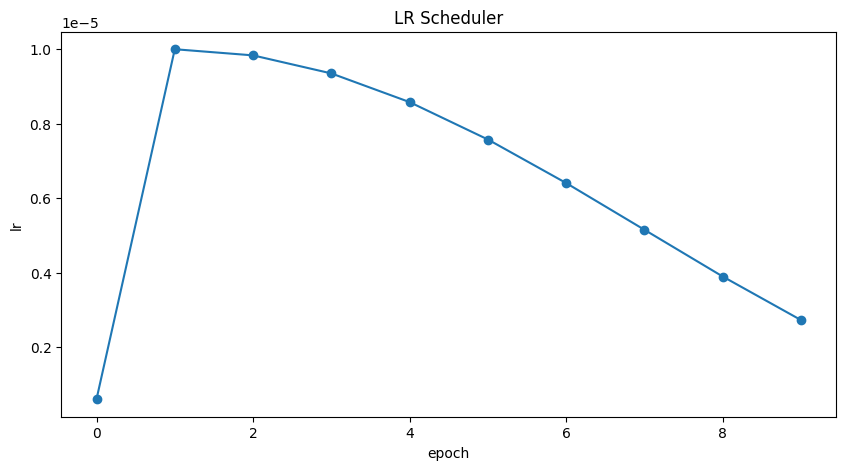

In [19]:
_=get_lr_callback(CFG.batch_size*CFG.replicas, plot=True)

# ☎️ | Callbacks

The function below will gather all the training callbacks, such as `lr_scheduler`, `model_checkpoint`, `wandb_logger`, and etc.

In [20]:
def get_callbacks(fold):
    callbacks = []
    lr_cb = get_lr_callback(CFG.batch_size*CFG.replicas)  # Get lr callback

    ckpt_cb = keras.callbacks.ModelCheckpoint(f'{CFG.MODEL_DIR}/{CFG.MODEL_NAME}_{fold}F.keras',
                                              monitor='val_auc',
                                              save_best_only=True,
                                              save_weights_only=False,
                                              mode='max')  # Get Model checkpoint callback
    callbacks.extend([lr_cb, ckpt_cb])  # Add lr and checkpoint callbacks

    if CFG.wandb:  # If WandB is enabled
        wb_cbs = get_wb_callbacks(fold+1)  # Get WandB callbacks
        callbacks.extend(wb_cbs) 
        
    return callbacks  # Return the list of callbacks

# 🤖 | Modeling



## KerasNLP Classifier

<img src="https://keras.io/img/logo.png" width="400">

The `KerasNLP` library provides comprehensive, ready-to-use implementations of popular NLP model architectures. It features a variety of pre-trained models including `Bert`, `Roberta`, `DebertaV3`, and more. In this notebook, we'll showcase the usage of `DebertaV3`. However, feel free to explore all available models in the [KerasNLP documentation](https://keras.io/api/keras_nlp/models/). Also for a deeper understanding of `KerasNLP`, refer to the informative [getting started guide](https://keras.io/guides/keras_nlp/getting_started/).

Our approach involves using `keras_nlp.models.XXClassifier` to process each text and generatie logits. These logits are passed through a `softmax` function to produce the final output.

In [21]:
def build_model():
    ## BERT Preprocess Data
    
    classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
        CFG.preset,
        preprocessor=None,
        num_classes=1
    )
    
    inputs = classifier.input
    logits = classifier(inputs)
        
    # Compute final output
    outputs = keras.layers.Activation("sigmoid")(logits)
    model = keras.Model(inputs, outputs)

    # Compile the model with optimizer, loss, and metrics
    model.compile(
        optimizer=keras.optimizers.AdamW(5e-6),
        loss=keras.losses.BinaryCrossentropy(label_smoothing=0.02),
        metrics=[
            keras.metrics.AUC(name="auc"),
        ],
        jit_compile=True
    )
    model.distribute_strategy = strategy
    return model

In [22]:
if CFG.LOAD_CKPT:
    ckpt_path = f'{CFG.MODEL_DIR}/{CFG.MODEL_NAME}.keras'
    print(ckpt_path)
    model = keras.models.load_model(
        ckpt_path,
        compile=False,
    )
else:
    model = build_model()

C:\Users\dinle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras_core\src\trainers\trainer.py:166: UserWarning: `jit_compile` is not yet enabled for the PyTorch backend. Proceeding with `jit_compile=False`.
  warnings.warn(


### Model Summary

In [23]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, None)      │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ token_ids           │ (None, None)      │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ deberta_v3_classif… │ (None, 1)         │ 141,89… │ padding_mask[0][0],  │
│ (DebertaV3Classifi… │                   │         │ token_ids[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation          │ (None, 1)         │       0 │ deberta_v3_classifi… │
│ (Activation)        │                   │         │                      │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 141,895,681 (541.29 MB)

 Trainable params: 141,895,681 (541.29 MB)

 Non-trainable params: 0 (0.00 B)

## Check Prediction

In [24]:
def check_prediction(pred_prob, origin_df, save):
    pred_label = (pred_prob > 0.5).astype(int).squeeze()
    print(f"Predict Shape: {pred_label.shape}")
    print("# Predictions\n")
    for i in range(3):
        row = test_df.iloc[i]
        text  = row.text
        pred_answer = CFG.label2name[pred_label[i]]
        print(f"❓ Text {i+1}:\n{text}\n")
        print(f"🤖 Predicted: {pred_answer}\n")
        print("-"*90, "\n")
    sub_df = origin_df.copy()

    # Add the formatted predictions to the submission DataFrame
    sub_df["pred_prob"] = pred_prob.squeeze()
    sub_df["pred_label"] = pred_label
    sub_df["correct"] = sub_df["pred_label"] == sub_df["label"]
    
    # Display the first 2 rows of the submission DataFrame
    sub_df.head(2)
    
    # Display Acc
    total_cor = sub_df["correct"].sum()
    total_acc = (total_cor * 100) / len(sub_df)
    print(f'Total Correct: {total_cor} / {len(sub_df)}')
    print(f'Acc: {total_acc:.2f} %')
    
    if save:
        file_name = f'{CFG.TEST_NAME}_({total_acc:.2f})'
        folder_path = CFG.TEST_DIR
        save_path = f'{folder_path}{file_name}.csv'
        if os.path.exists(save_path):
            i = 1
            save_path = f'{folder_path}{file_name}{i}.csv'
            # 새로운 파일 이름 생성
            while os.path.exists(save_path):
                i += 1
                save_path = f'{folder_path}{file_name}{i}.csv'
        elif not os.path.exists(folder_path):
            os.makedirs(folder_path)
        sub_df.to_csv(f'{save_path}',index=False)
        print(f'파일이 {save_path}에 저장되었습니다.')
    
        if CFG.MAKE_SUBMISSION:
            sub_df.to_csv(f'{CFG.WORKING_PATH}/submission.csv',index=False)
            
    return sub_df

### Prediction Without Fine-Tuning

In [25]:
if CFG.TEST_WOFT:
    test_ds = get_test_dataset()
    # Generate predictions using the model
    pred_result_wo_ft = model.predict(
        test_ds,
        batch_size=min(CFG.batch_size * CFG.replicas, len(test_df)),  # Set batch size
        verbose=1
    )
    
    pred_result_wo_ft = pred_result_wo_ft.squeeze()
    submission_WOFT = check_prediction(pred_result_wo_ft, test_df, 'submission_woft')

# 🚂 | Training

In [26]:
if CFG.TRAIN:
    for fold in CFG.selected_folds:
        # Initialize Weights and Biases if enabled
        if CFG.wandb:
            run = wandb_init(fold + 1)
    
        # Get train and validation datasets
        (tr_ds, tr_df), (vl_ds, vl_df) = get_train_datasets(fold)
        
        # Get callback functions for training
        callbacks = get_callbacks(fold + 1)
    
        # Print training information
        print('#' * 50)
        print(f'\tFold: {fold + 1} | Model: {CFG.preset}\n\tBatch Size: {CFG.batch_size * CFG.replicas} | Scheduler: {CFG.scheduler}')
        print(f'\tNum Train: {len(tr_df)} | Num Valid: {len(vl_df)}')
        print('#' * 50)
        
        # Clear TensorFlow session and build the model within the strategy scope
        K.clear_session()
        with strategy.scope():
            model = build_model()
    
        # Start training the model
        history = model.fit(
            tr_ds,
            epochs=CFG.epochs,
            validation_data=vl_ds,
            callbacks=callbacks,
            steps_per_epoch=int(len(tr_df) / CFG.batch_size / CFG.replicas),
        )
        
        # Find the epoch with the best validation accuracy
        best_epoch = np.argmax(model.history.history['val_auc'])
        best_auc = model.history.history['val_auc'][best_epoch]
        best_loss = model.history.history['val_loss'][best_epoch]
    
        # Print and display best results
        print(f'\n{"=" * 17} FOLD {fold + 1} RESULTS {"=" * 17}')
        print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST AUC   : {best_auc:.3f}\n>>>> BEST Epoch : {best_epoch}')
        print('=' * 50)
        
        # Log best result on Weights and Biases (wandb) if enabled
        if CFG.wandb:
            log_wandb()  # Log results
            wandb.run.finish()  # Finish the run
    #         display(ipd.IFrame(run.url, width=1080, height=720)) # show wandb dashboard
        print("\n\n")

wandb: Currently logged in as: dinleo11. Use `wandb login --relogin` to force relogin


##################################################
	Fold: 1 | Model: deberta_v3_small_en
	Batch Size: 20 | Scheduler: cosine
	Num Train: 4000 | Num Valid: 1000
##################################################
Epoch 1/3
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - auc: 0.5179 - loss: 0.6947

wandb: ERROR Unable to log learning rate.


200/200 ━━━━━━━━━━━━━━━━━━━━ 1380s 7s/step - auc: 0.5181 - loss: 0.6947 - val_auc: 0.9979 - val_loss: 0.6754 - learning_rate: 6.0000e-07
Epoch 2/3
200/200 ━━━━━━━━━━━━━━━━━━━━ 1399s 7s/step - auc: 0.9590 - loss: 0.2827 - val_auc: 1.0000 - val_loss: 0.0893 - learning_rate: 1.0000e-05
Epoch 3/3
200/200 ━━━━━━━━━━━━━━━━━━━━ 1558s 8s/step - auc: 0.9998 - loss: 0.0630 - val_auc: 1.0000 - val_loss: 0.0687 - learning_rate: 9.8347e-06

================= FOLD 1 RESULTS =================
>>>> BEST Loss  : 0.069
>>>> BEST AUC   : 1.000
>>>> BEST Epoch : 2


best_auc,▁
best_epoch,▁
best_loss,▁
epoch/auc,▁██
epoch/epoch,▁▅█
epoch/learning_rate,▁██
epoch/loss,█▂▁
epoch/val_auc,▁██
epoch/val_loss,█▁▁
best_auc,0.99998
best_epoch,2


## Training Log
### [Click Here ➡️](https://wandb.ai/awsaf49/llm-science-exam-public) to check all the training logs in **WandB** dashboard.

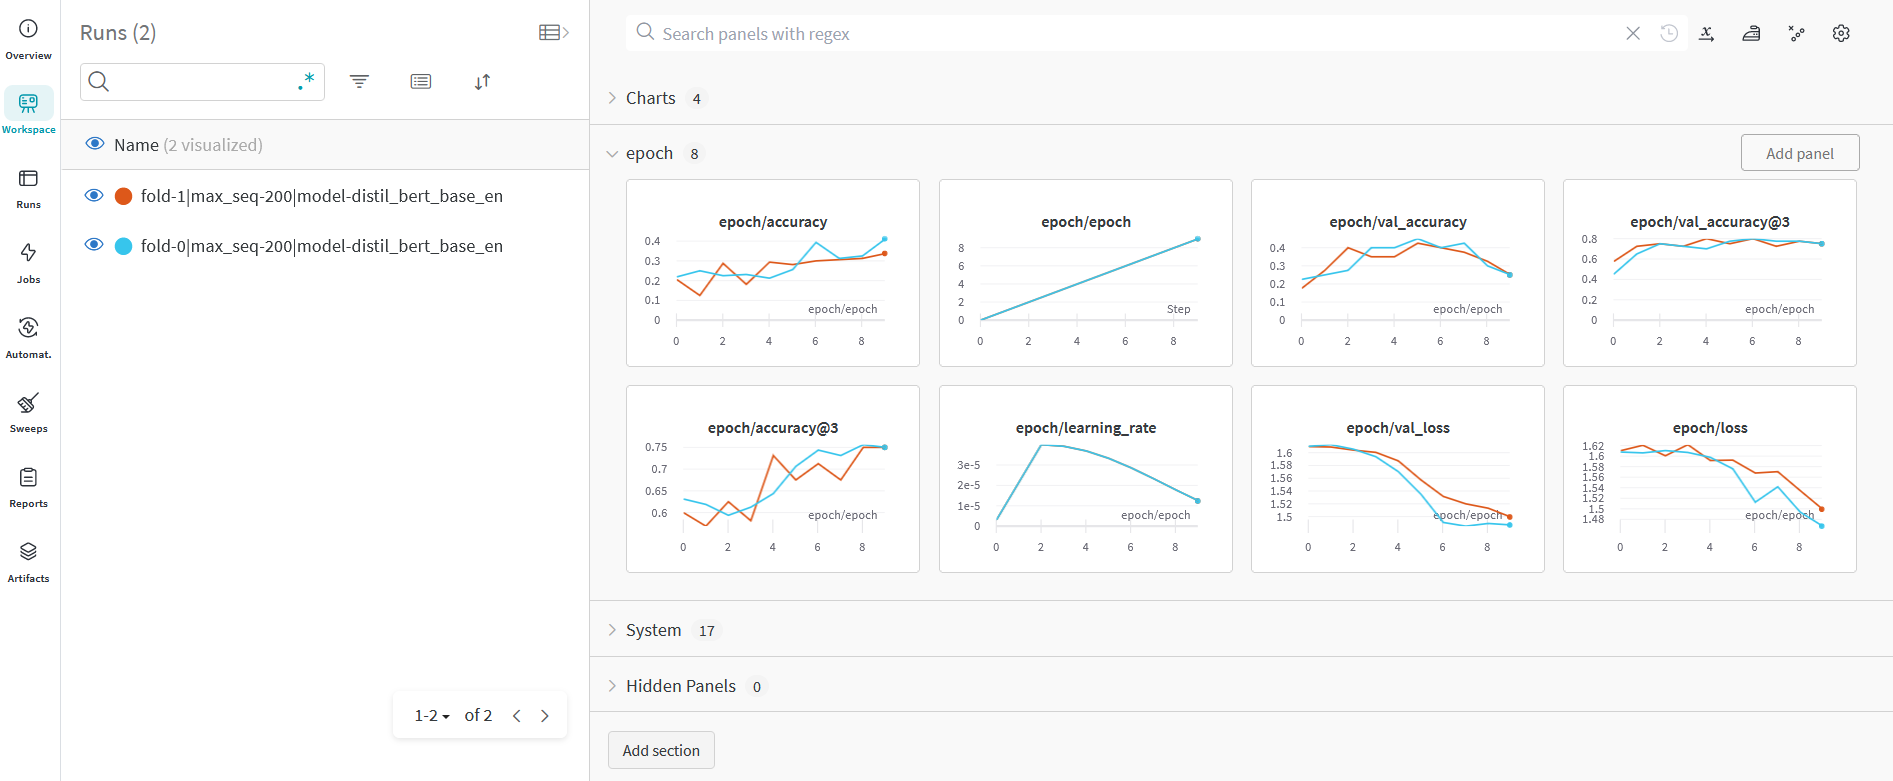

# 🧪 | TEST

In [27]:
if CFG.TEST:
    test_ds = get_test_dataset()
    pred_result = model.predict(
        test_ds,
        batch_size=min(CFG.batch_size * CFG.replicas, len(test_df)), # max batch size = valid size
        verbose=1
    )
    submission = check_prediction(pred_result, test_df, True)

50/50 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step
Predict Shape: (1000,)
# Predictions

❓ Text 1:
Us people that do want to do it should not do all day community service like the others. Also don` t punish the other people bad. They are just not helpful enough or just don't want to do nothing at all. 

🤖 Predicted: real

------------------------------------------------------------------------------------------ 

❓ Text 2:
But really every one's vote does. 

🤖 Predicted: fake

------------------------------------------------------------------------------------------ 

❓ Text 3:
A tie can be possible in electorals votes but, the total number of votes is 538 which is an even number but, is not very likely that it would happen. 


🤖 Predicted: real

------------------------------------------------------------------------------------------ 

Total Correct: 625 / 1000
Acc: 62.50 %
파일이 ./kaggle/working//test/(deberta_v3_small_en)_(daigt-proper-train-dataset)/(5.0K_3E)_(feedback-prize-effectiveness)/(tra

### Compare

In [28]:
if CFG.TEST_WOFT and CFG.TEST:
    from sklearn.metrics import f1_score
    f1_WOFT = f1_score(submission_WOFT['label'], submission_WOFT['pred_label'])
    f1 = f1_score(submission['label'], submission['pred_label'])
    
    print(f'F1 Without FT: {f1_WOFT}')
    print(f'F1 With FT: {f1}')